In [1]:
import os
import os.path
import sys
d = os.path.join(os.getcwd(), '..')
print(d)
sys.path.append(d)

C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..


In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure as Figure
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'png'

# https://pandas.pydata.org/pandas-docs/stable/visualization.html
# http://pandas.pydata.org/pandas-docs/version/0.13/visualization.html
# https://matplotlib.org/users/pyplot_tutorial.html

# Set up the style of the graphs, and display a sample graph
graph_style = 5
plt.style.use(plt.style.available[graph_style])  # 5, 14, 22
plt.figure(figsize=(30, 15))
sns.set_context("paper")

Warning! Takes approximately 45 seconds per decade
Warning! Takes approximately 45 seconds per decade


,Longitude (Range shifted),Latitude (Range shifted)
City,,
0,-20341.66665,14175.0000
1,-20174.99995,14291.6667
2,-20158.33335,13891.6667
3,-20108.33335,14075.0000
4,-20108.33335,13908.3333
5,-20091.66665,14241.6667
6,-20041.66665,14375.0000
7,-20041.66665,13725.0000
8,-20008.33335,14075.0000


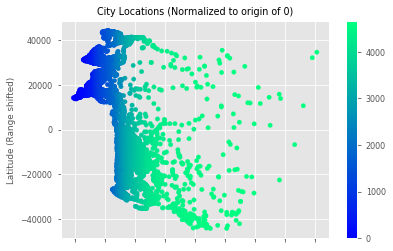

In [3]:
# Set Imports

# These imports do not need to change between runs.
from src.EA_Shell import EARunner as EA
from src.Setups.TSP.TSP_Display import GraphingHelper as Grapher


# Modular Imports

# By changing these imports, you can easily redifine the problem you are attempting to solve,
# and the problem representation, without having to re-write much of the code.
from src.EA_Methods.List_Rep import ParentSelectionMethods as PSM
from src.EA_Methods.List_Rep import MutationMethods as MM
from src.EA_Methods.List_Rep import RecombinationMethods as RM
from src.EA_Methods.List_Rep import SurvivorSelectionMethods as SSM
from src.EA_Methods.List_Rep import PopulationManagementMethods as PMM
from src.Setups.TSP import TSP_LST as DEF


# Shell Object And Master Variable Initialization

# Select which TSP instance to solve
FILENUM             =      3

# Determine the genome length and initialize key data
genome_length       =      DEF.read_tsp_file(FILENUM)

# Give the EARunner direct access to the modules which implement 
# various algortihms for each step of the EA, and their globals.
ea                  =      EA(PSM, RM, MM, SSM, DEF, PMM)

# Initialize the grapher with the appropriate data
grapher             =      Grapher(FILENUM)
grapher.start_up_display()
grapher.cities

In [4]:
# Modular Function Definitions

# By swapping out which functions are imported, but keeping the aliases,
# the entire structure of the EA can be changed without rewriting code
# in the main method.
initialize           = DEF.heuristic_cluster_initialization
eval_fitness         = DEF.euclidean_distance
parent_selection     = PSM.tournament
generate_offspring   = RM.order_crossover
apply_mutation       = MM.permutation_inversion
select_survivors     = SSM.replacement
prune_population     = PMM.ouroboric_culling


# Set the desired functions and for the EA.
# Important note: The EARunner has a helper class which stores and handles the variables
# when it runs. It can be accessed after this call to set various rates and amounts.
ea.set_params(genome_length, eval_fitness, initialize, parent_selection, generate_offspring,
              apply_mutation, select_survivors, prune_population)


# Global Variable Initialization
generation_limit    =      100
print_snapshot      =      generation_limit // 100

In [5]:
op_fit, best_indivs, gencount, run_history, time_tuple = ea.run(generation_limit, print_gens=print_snapshot)

Generation: 1
  Best fitness: 24637964.356090292
  Avg. fitness: 25057513.92018742
Generation: 2
  Best fitness: 24637964.356090292
  Avg. fitness: 24937234.575888198
Generation: 3
  Best fitness: 24552610.432833742
  Avg. fitness: 24851329.439327475
Generation: 4
  Best fitness: 24523668.884762492
  Avg. fitness: 24740180.91487197
Generation: 5
  Best fitness: 24422096.090278383
  Avg. fitness: 24630873.7911519
Generation: 6
  Best fitness: 24422096.090278383
  Avg. fitness: 24569663.926864665
Generation: 7
  Best fitness: 24422096.090278383
  Avg. fitness: 24537098.387372296
Generation: 8
  Best fitness: 24422096.090278383
  Avg. fitness: 24505336.82206416
Generation: 9
  Best fitness: 24422096.090278383
  Avg. fitness: 26224366.79009737
Generation: 10
  Best fitness: 24422096.090278383
  Avg. fitness: 31530607.92007253
Generation: 11
  Best fitness: 24418948.044193354
  Avg. fitness: 24434856.005880557
Generation: 12
  Best fitness: 24416056.38737595
  Avg. fitness: 24428981.6823682

Generation: 99
  Best fitness: 24293763.007056847
  Avg. fitness: 34856087.37865323
Generation: 100
  Best fitness: 24293763.007056847
  Avg. fitness: 33097946.065994896
Best solution fitness: 24293469.99158929
Number of optimal solutions:  1 / 60
Best solution indexes: [53]
Best solution path: [4652, 4595, 4405, 4458, 4489, 4583, 4409, 4557, 4393, 4589, 4525, 4608, 4607, 4587, 4655, 4550, 4647, 4590, 4653, 4651, 4506, 4637, 4627, 4629, 4535, 4562, 4648, 4639, 4600, 4625, 4659, 1847, 2500, 2667, 2250, 2641, 2686, 2865, 2377, 3137, 3226, 1973, 4373, 2924, 2065, 2587, 2883, 4245, 1953, 2585, 2004, 1994, 2792, 2621, 2717, 2426, 2388, 2937, 2791, 2726, 2054, 1793, 4371, 4389, 1929, 2306, 2438, 2661, 2776, 3031, 2715, 3727, 2786, 2284, 2237, 2335, 2446, 1954, 2032, 2968, 2613, 2156, 2760, 2483, 3614, 1960, 2324, 2852, 2605, 3550, 3201, 3779, 2752, 3162, 2843, 2976, 1961, 2975, 2949, 3700, 2896, 2234, 4282, 1944, 3143, 2539, 2499, 3097, 2693, 2046, 2197, 2812, 2015, 2425, 2376, 3454, 2604, 3

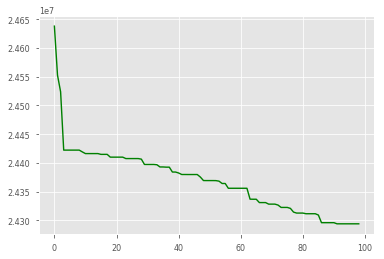

In [6]:
df = pd.DataFrame(run_history)
df.columns = ['Fitness', 'Route']
df['Fitness'].plot(color='green')

Generation 9    : 24418948.04
Generation 18   : 24409856.50
Generation 29   : 24397129.01
Generation 38   : 24383922.44
Generation 47   : 24375178.27
Generation 56   : 24355656.76
Generation 66   : 24330740.70
Generation 76   : 24320615.59
Generation 85   : 24309044.38
Generation 100  : 24293763.01


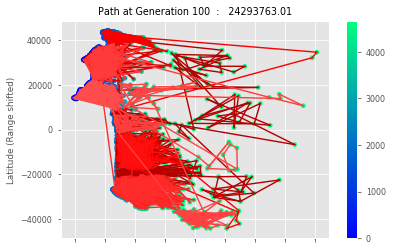

In [7]:
from math import pi, sin, cos  

counter = 0
prev = 0
last_sig = run_history[0][0]
plottable_tuples = []
for x in range(0, generation_limit-1):
    counter += 1
    fitness = run_history[x][0]
    
    if fitness != prev and counter >= 10 and last_sig - fitness > 5000:
        last_sig = fitness
        plottable_tuples.append((x, fitness, run_history[x][1]))
        counter = 1
    
    prev = fitness

plottable_tuples.append((generation_limit, run_history[-1][0], run_history[-1][1]))    
for x in plottable_tuples:
    print('Generation {: <5}: {:4.2f}'.format(x[0], x[1]))
    
grapher.generation_display(generation_limit, run_history[-1][0], run_history[-1][1])

In [8]:
def alt_graph():
    x = grapher.cities[grapher.long_names[0]]
    y = grapher.cities[grapher.long_names[1]]

    for i in range(len(grapher.cities)):
        c1 = run_history[-1][1][i]
        c2 = run_history[-1][1][i % len(grapher.cities)-1]
        per = pi * i / len(grapher.cities)
        red_mod = max(cos(per), 0) * 0.3
        bright_mod = -min(cos(per), 0) * 0.3
        plt.plot([x[c1], x[c2]], [y[c1], y[c2]], color=[1-red_mod, bright_mod, bright_mod], marker='o')
    plt.title('City Locations (Normalized to origin of 0)')
    plt.show()

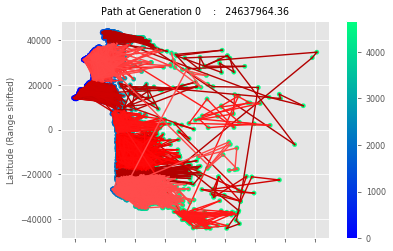

In [9]:
grapher.generation_display(0, run_history[0][0], run_history[0][1])

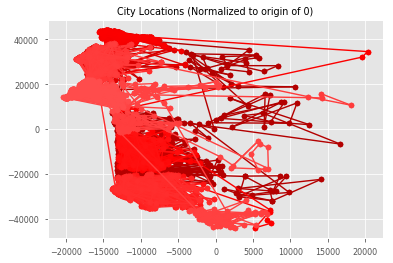

In [10]:
alt_graph()
# grapher.alt_generation_display(0, run_history[0][0], run_history[0][1])